### This Notebook is used for the Applied Datascience Capstone Project. 

### The Capstone project is the culminating activity for the IBM Datascience Professional Certificate. The Certificate covers a broad range of topics ranging from data science methodology, data analysis with python to data visualization and machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import folium
import lxml
import requests
import re
import xlrd
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
#Foursquare details
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
#load postal code and area code data for ease of mapping
coordinates_url = "./data/neighborhoods/Geospatial_Coordinates.csv"
df_coordinates = pd.read_csv(coordinates_url)
df_coordinates=df_coordinates.rename(columns={"Postal Code":"area"})

In [4]:
# helper function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#function to sort according venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#helper function to process an address
def get_location(location):
    address = location.area
    center_latitude = location.Latitude
    center_longitude = location.Longitude
    temp_list = []
    radius = 500
    LIMIT = 100
    foursquare_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    center_latitude, 
    center_longitude, 
    radius, 
    LIMIT)
    
    # make the GET request
    print(address)
    results = requests.get(foursquare_url).json()["response"]['groups'][0]['items']  
    # return only relevant information for each nearby venue
    temp_list.extend([(
            address, 
            center_latitude, 
            center_longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    return temp_list

### Examine business permit data

In [5]:
#import business permit data
fields_used=["Client Name","Category","Licence Address Line 3"]
df_biz_raw=pd.read_csv("./data/neighborhoods/Business-licences-data.csv",usecols=fields_used)
print('There are {} uniques categories.'.format(len(df_biz_raw['Category'].unique())))
#get unique categories
print(df_biz_raw['Category'].unique())

There are 87 uniques categories.
['PRIVATE TRANSPORTATION COMPANY' 'TAXICAB BROKER'
 'LIMOUSINE SERVICE COMPANY' 'PRIVATE PARKING ENFORCEMENT AGENCY'
 'DRIVING SCHOOL OPERATOR (B)' 'DRIVE-SELF RENTAL OWNER' 'HOLISTIC CENTRE'
 'ADULT ENTERTAINMENT CLUB' 'PLACE OF AMUSEMENT' 'BILLIARD HALL'
 'TEMPORARY SIGN PROVIDER' 'BODY RUB PARLOUR' 'BOWLING HOUSE'
 'BOATS FOR HIRE' 'CARNIVAL' 'CIRCUS' 'SMOKE SHOP' 'RETAIL STORE (FOOD)'
 'PERSONAL SERVICES SETTINGS' 'LAUNDRY' 'MOTOR VEHICLE RACING' 'THEATRE'
 'PRECIOUS METAL SHOP' 'PAWN SHOP' 'PET SHOP' 'BATH HOUSE' 'PUBLIC GARAGE'
 'AUTO SERVICE STATION' 'PUBLIC HALL' 'EATING ESTABLISHMENT'
 'SECOND HAND DEALER' 'SECOND HAND SHOP' 'SECOND HAND SALVAGE YARD'
 'SECOND HAND SALVAGE SHOP' 'COMMERCIAL PARKING LOT' 'SWIMMING POOL'
 'PAYDAY LOAN' 'CLOTHING DROP BOX OPERATOR'
 'ENTERTAINMENT ESTABLISHMENT/NIGHTCLUB' 'TEMPORARY SIGN - A-FRAME'
 'TEMPORARY SIGN - MOBILE' 'TEMPORARY SIGN - NEW DEVELOPMENT'
 'TEMPORARY SIGN - GROUND-MOUNTED' 'TEMPORARY SIGN - PO

In [6]:
#split out the address to get the area/neighborhood
df_biz_raw.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_tmp=df_biz_raw['Licence Address Line 3'].str.split(" ", n = 1, expand = True) 
df_biz_raw['area']=df_tmp[0]
df_biz_raw=df_biz_raw.dropna()
df_biz_raw=df_biz_raw[df_biz_raw['area'].str.startswith('M')]

In [7]:
#Group out categories
df_biz_raw["CATEGORY GROUP"]="Other"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('refreshment|hortons|cafe|café|bar|restaurant|diner|pub|eating',flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Food/Beverage"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('pizza|salad|ice cream|steak|tea|dessert|poke place|coffee|breakfast|smoothie', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Food/Beverage"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('theater|music|opera|concert|entertainment|circus|carnival|amusement', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Entertainment"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('taxicab|limousine|transportation|pedicab', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Transportation"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('contractor|installer|plumbing|heating|repairman|renovator|insulator|layer', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Contractor/Repairman"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('sign|display', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Temporary Sign"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('fireworks', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Fireworks"
df_biz_raw.loc[df_biz_raw["Category"].str.contains('laundry|personal|parlour', flags=re.IGNORECASE, regex=True),["CATEGORY GROUP"]]="Services"

print(df_biz_raw['CATEGORY GROUP'].unique())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)


['Transportation' 'Other' 'Entertainment' 'Temporary Sign' 'Services'
 'Food/Beverage' 'Fireworks' 'Contractor/Repairman']


In [8]:
df_biz_raw

Category  \
0                PRIVATE TRANSPORTATION COMPANY   
1                PRIVATE TRANSPORTATION COMPANY   
2                PRIVATE TRANSPORTATION COMPANY   
3                PRIVATE TRANSPORTATION COMPANY   
4                PRIVATE TRANSPORTATION COMPANY   
...                                         ...   
160258  NON-MOTORIZED REFRESHMENT VEHICLE OWNER   
160260  NON-MOTORIZED REFRESHMENT VEHICLE OWNER   
160262  NON-MOTORIZED REFRESHMENT VEHICLE OWNER   
160263  NON-MOTORIZED REFRESHMENT VEHICLE OWNER   
160265  NON-MOTORIZED REFRESHMENT VEHICLE OWNER   

                                            Client Name  \
0                                     TAXIFY CANADA INC   
1                                         INSTARYDE INC   
2                                       UBER CANADA INC   
3                                         FACEDRIVE INC   
4                                              RIDE INC   
...                                                 ...   
160258                                       KAYLUN INC   
160260  WOYTIUK,ROBYN DANIELLE/ZAVARELLA,FREDO LAURENCE   
160262                              1990618 ONTARIO INC   
160263                                  KESEROVIC, OLGA   
160265                             KHALFALLAH, MOHAMMED   

       Licence Address Line 3 area  CATEGORY GROUP  
0                     M9N 1A1  M9N  Transportation  
1                     M3J 2T8  M3J  Transportation  
2                     M4W 3M5  M4W  Transportation  
3                     M2J 4R4  M2J  Transportation  
4                     M8Z 3B1  M8Z  Transportation  
...                       ...  ...             ...  
160258                M4P 0B9  M4P   Food/Beverage  
160260                M5B 0B4  M5B   Food/Beverage  
160262                M6B 2S3  M6B   Food/Beverage  
160263                    M4A  M4A   Food/Beverage  
160265                    M1T  M1T   Food/Beverage  

[138219 rows x 5 columns]

In [9]:
# one hot encoding
df_one_hot_encoded = pd.get_dummies(df_biz_raw[['CATEGORY GROUP']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_one_hot_encoded['area'] = df_biz_raw['area'] 

# move neighborhood column to the first column
fixed_columns = [df_one_hot_encoded.columns[-1]] + list(df_one_hot_encoded.columns[:-1])
df_one_hot_encoded = df_one_hot_encoded[fixed_columns]
df_one_hot_encoded.sort_values(['area'], ascending=False, inplace=True)
df_sums=df_one_hot_encoded.groupby(['area']).sum().reset_index()
df_sums

area  Contractor/Repairman  Entertainment  Fireworks  Food/Beverage  \
0    M1B                 141.0           20.0        4.0          533.0   
1    M1C                 161.0            2.0        3.0          432.0   
2    M1E                 191.0            7.0       15.0          701.0   
3    M1G                  90.0            5.0        7.0          164.0   
4    M1H                  77.0           21.0       19.0          456.0   
5    M1J                  80.0            9.0        8.0          548.0   
6    M1K                 178.0           27.0       14.0          988.0   
7    M1L                 168.0           22.0       21.0         1342.0   
8    M1M                 169.0           10.0        8.0          403.0   
9    M1N                 152.0            1.0       16.0          371.0   
10   M1P                 140.0           24.0       28.0         1301.0   
11   M1R                 153.0           18.0       15.0          791.0   
12   M1S                 160.0           93.0        6.0          955.0   
13   M1T                  82.0           19.0       10.0          402.0   
14   M1V                 206.0           23.0        5.0         1029.0   
15   M1W                 122.0           14.0        2.0          347.0   
16   M1X                  64.0            4.0        0.0          105.0   
17   M2B                   0.0            0.0        0.0            0.0   
18   M2G                   0.0            0.0        0.0            2.0   
19   M2H                  69.0            5.0        1.0          230.0   
20   M2J                 152.0           19.0        1.0          543.0   
21   M2K                  44.0            3.0        8.0          172.0   
22   M2L                  29.0            0.0        0.0           39.0   
23   M2M                 123.0           28.0       10.0          464.0   
24   M2N                 142.0           70.0        0.0         1001.0   
25   M2P                  12.0            0.0        1.0           52.0   
26   M2R                 132.0           14.0        9.0          134.0   
27   M2S                   0.0            0.0        0.0            0.0   
28   M3A                  95.0            1.0        0.0          140.0   
29   M3B                  54.0            4.0        0.0          299.0   
30   M3C                  68.0           12.0        0.0          418.0   
31   M3H                 171.0           28.0        4.0          603.0   
32   M3J                 158.0           53.0       14.0         2402.0   
33   M3K                  60.0            7.0        1.0          362.0   
34   M3L                  47.0           11.0       12.0          205.0   
35   M3M                 106.0           13.0        4.0          195.0   
36   M3N                  82.0           18.0        5.0          511.0   
37   M3P                   0.0            0.0        0.0            0.0   
38   M3T                   0.0            0.0        0.0            0.0   
39   M3Y                   0.0            0.0        0.0            0.0   
40   M4A                  59.0           17.0        3.0          216.0   
41   M4B                 148.0            1.0        1.0          317.0   
42   M4C                 244.0           26.0       13.0          836.0   
43   M4E                 128.0            5.0        0.0          454.0   
44   M4G                  97.0            3.0        2.0          403.0   
45   M4H                  32.0            1.0        4.0          145.0   
46   M4J                 191.0           27.0        1.0          893.0   
47   M4K                 160.0           10.0        1.0          901.0   
48   M4L                 188.0            8.0        2.0          886.0   
49   M4M                 131.0           29.0        5.0          968.0   
50   M4N                  40.0            3.0        1.0          283.0   
51   M4P                  35.0           11.0        0.0          577.0   
52   M4R                  24.

In [11]:
#Transpose for plotting
fig=plt.figure(figsize=(20,10))
df_sums_T=df_sums.T
#
for area_x in (list(df_sums_T.columns)[:20]):
    df_sums_Tg=df_sums_T.iloc[1:]
    plt.plot( df_sums_Tg.index,df_sums_Tg[area_x].values, alpha=0.5)
    
print(list(df_sums['area'])[:20])
print(df_sums[:20])
plt.legend(list(df_sums['area'])[:20], loc="upper left")
plt.show()

['M1B', 'M1C', 'M1E', 'M1G', 'M1H', 'M1J', 'M1K', 'M1L', 'M1M', 'M1N', 'M1P', 'M1R', 'M1S', 'M1T', 'M1V', 'M1W', 'M1X', 'M2B', 'M2G', 'M2H']
   area  Contractor/Repairman  Entertainment  Fireworks  Food/Beverage  \
0   M1B                 141.0           20.0        4.0          533.0   
1   M1C                 161.0            2.0        3.0          432.0   
2   M1E                 191.0            7.0       15.0          701.0   
3   M1G                  90.0            5.0        7.0          164.0   
4   M1H                  77.0           21.0       19.0          456.0   
5   M1J                  80.0            9.0        8.0          548.0   
6   M1K                 178.0           27.0       14.0          988.0   
7   M1L                 168.0           22.0       21.0         1342.0   
8   M1M                 169.0           10.0        8.0          403.0   
9   M1N                 152.0            1.0       16.0          371.0   
10  M1P                 140.0           24.0 

In [12]:
df_biz_counts=df_biz_raw.groupby(['area','CATEGORY GROUP']).count().reset_index().sort_values(['area'], ascending=False)
df_biz_counts.head(20)

area        CATEGORY GROUP  Category  Client Name  Licence Address Line 3
767  M9X                 Other         1            1                       1
766  M9X         Food/Beverage         1            1                       1
762  M9W                 Other       952          952                     952
759  M9W         Entertainment        43           43                      43
760  M9W             Fireworks        61           61                      61
761  M9W         Food/Beverage      1704         1704                    1704
758  M9W  Contractor/Repairman       238          238                     238
763  M9W              Services       147          147                     147
764  M9W        Temporary Sign       217          217                     217
765  M9W        Transportation       236          236                     236
757  M9V        Transportation       135          135                     135
756  M9V        Temporary Sign       130          130                     130
755  M9V              Services       182          182                     182
754  M9V                 Other       782          782                     782
753  M9V         Food/Beverage       610          610                     610
752  M9V             Fireworks        31           31                      31
751  M9V         Entertainment        42           42                      42
750  M9V  Contractor/Repairman       117          117                     117
745  M9R         Food/Beverage       119          119                     119
743  M9R  Contractor/Repairman        90           90                      90

In [13]:
pd.merge(df_biz_counts, df_coordinates, on='area')

area        CATEGORY GROUP  Category  Client Name  Licence Address Line 3  \
0    M9W                 Other       952          952                     952   
1    M9W         Entertainment        43           43                      43   
2    M9W             Fireworks        61           61                      61   
3    M9W         Food/Beverage      1704         1704                    1704   
4    M9W  Contractor/Repairman       238          238                     238   
..   ...                   ...       ...          ...                     ...   
740  M1B         Entertainment        20           20                      20   
741  M1B              Services       113          113                     113   
742  M1B        Temporary Sign       129          129                     129   
743  M1B        Transportation       102          102                     102   
744  M1B  Contractor/Repairman       141          141                     141   

      Latitude  Longitude  
0    43.706748 -79.594054  
1    43.706748 -79.594054  
2    43.706748 -79.594054  
3    43.706748 -79.594054  
4    43.706748 -79.594054  
..         ...        ...  
740  43.806686 -79.194353  
741  43.806686 -79.194353  
742  43.806686 -79.194353  
743  43.806686 -79.194353  
744  43.806686 -79.194353  

[745 rows x 7 columns]

In [17]:
df_sums.describe()

Contractor/Repairman  Entertainment   Fireworks  Food/Beverage  \
count            120.000000     120.000000  120.000000     120.000000   
mean              81.791667      12.966667    4.616667     484.983333   
std               70.188330      16.865724    9.082427     460.856783   
min                0.000000       0.000000    0.000000       0.000000   
25%               11.500000       1.000000    0.000000     104.250000   
50%               72.500000       8.000000    1.000000     403.000000   
75%              140.250000      19.000000    5.250000     701.750000   
max              244.000000      94.000000   61.000000    2402.000000   

             Other    Services  Temporary Sign  Transportation  
count   120.000000  120.000000      120.000000      120.000000  
mean    369.066667  101.925000       36.241667       60.233333  
std     293.166793   86.332479       43.433325       61.319762  
min       0.000000    0.000000        0.000000        0.000000  
25%     128.750000   28.750000        6.000000        8.500000  
50%     344.000000   89.000000       25.500000       45.500000  
75%     557.250000  155.250000       46.250000       94.750000  
max    1240.000000  406.000000      217.000000      276.000000

In [18]:
df_filtered_count=df_biz_counts[df_biz_counts['CATEGORY GROUP']=="Food/Beverage"]
df_filtered_count.sort_values('Client Name')

area CATEGORY GROUP  Category  Client Name  Licence Address Line 3
766  M9X  Food/Beverage         1            1                       1
527  M5Y  Food/Beverage         1            1                       1
529  M5Z  Food/Beverage         1            1                       1
136  M2G  Food/Beverage         2            2                       2
644  M7B  Food/Beverage         3            3                       3
642  M7A  Food/Beverage         7            7                       7
162  M2L  Food/Beverage        39           39                      39
184  M2P  Food/Beverage        52           52                      52
465  M5L  Food/Beverage        64           64                      64
366  M4R  Food/Beverage        79           79                      79
595  M6L  Food/Beverage        91           91                      91
462  M5K  Food/Beverage        92           92                      92
480  M5N  Food/Beverage        96           96                      96
523  M5X  Food/Beverage       100          100                     100
486  M5P  Food/Beverage       102          102                     102
130  M1X  Food/Beverage       105          105                     105
386  M4V  Food/Beverage       118          118                     118
745  M9R  Food/Beverage       119          119                     119
192  M2R  Food/Beverage       134          134                     134
200  M3A  Food/Beverage       140          140                     140
312  M4H  Food/Beverage       145          145                     145
738  M9P  Food/Beverage       158          158                     158
27   M1G  Food/Beverage       164          164                     164
156  M2K  Food/Beverage       172          172                     172
691  M9A  Food/Beverage       188          188                     188
254  M3M  Food/Beverage       195          195                     195
246  M3L  Food/Beverage       205          205                     205
472  M5M  Food/Beverage       211          211                     211
273  M4A  Food/Beverage       216          216                     216
140  M2H  Food/Beverage       230          230                     230
400  M4X  Food/Beverage       247          247                     247
675  M8Y  Food/Beverage       257          257                     257
668  M8X  Food/Beverage       268          268                     268
352  M4N  Food/Beverage       283          283                     283
207  M3B  Food/Beverage       299          299                     299
380  M4T  Food/Beverage       310          310                     310
281  M4B  Food/Beverage       317          317                     317
435  M5E  Food/Beverage       328          328                     328
430  M5C  Food/Beverage       343          343                     343
123  M1W  Food/Beverage       347          347                     347
699  M9B  Food/Beverage       360          360                     360
238  M3K  Food/Beverage       362          362                     362
75   M1N  Food/Beverage       371          371                     371
107  M1T  Food/Beverage       402          402                     402
67   M1M  Food/Beverage       403          403                     403
304  M4G  Food/Beverage       403          403                     403
214  M3C  Food/Beverage       418          418                     418
11   M1C  Food/Beverage       432          432                     432
541  M6B  Food/Beverage       437          437                     437
296  M4E  Food/Beverage       454          454                     454
35   M1H  Food/Beverage       456          456                     456
170  M2M  Food/Beverage       464          464                     464
707  M9C  Food/Beverage       468          468                     468
661  M8W  Food/Beverage       479          479                     479
457  M5J  Food/Beverage       499          499                     499
634  M6S  Food/Beverage     

### Obserations:

#### 1. There are some business types that are not represented such as schools and banks.
#### 2. Among the listed businesses, food related businesses have the highest presence.
#### 3. There doesn't seem to be any obvious pattern to the business registrations for food and beverage apart from being the largest group in its own category. 
#### We note down the top 5 areas (M9L, M5T, M9W, M5V, M3J) for a closer look for any insight on opportunities.



### Examine Demographic Data

In [19]:
#load demographic data
demographic_file='./data/neighborhoods/wellbeing-toronto-demographics.xlsx'
df_demographics = pd.read_excel(demographic_file,
                     sheet_name='RawData-Ref Period 2008',header=1)
#clean out extra spaces in column names
df_demographics.columns=df_demographics.columns.str.strip()
df_demographics[['Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]


Neighbourhood  Total Area  Total Population  \
0               West Humber-Clairville       30.09             32265   
1    Mount Olive-Silverstone-Jamestown        4.60             32130   
2         Thistletown-Beaumond Heights        3.40              9925   
3                      Rexdale-Kipling        2.50             10725   
4                     Elms-Old Rexdale        2.90              9440   
5        Kingsview Village-The Westway        5.10             21395   
6     Willowridge-Martingrove-Richview        5.50             20920   
7             Humber Heights-Westmount        2.80             10525   
8             Edenbridge-Humber Valley        5.50             14450   
9                   Princess-Rosethorn        5.20             10965   
10      Eringate-Centennial-West Deane        8.60             18535   
11                       Markland Wood        2.90             10240   
12                 Etobicoke West Mall        1.70             10680   
13          Islington-City Centre West       16.40             32815   
14                      Kingsway South        2.60              8790   
15                 Stonegate-Queensway        7.90             23815   
16                              Mimico        6.90             24965   
17                         New Toronto        3.50             10655   
18                         Long Branch        2.30              9625   
19                           Alderwood        5.00             11655   
20                       Humber Summit        7.90             12770   
21                          Humbermede        4.40             14780   
22                Pelmo Park-Humberlea        4.20              8725   
23                         Black Creek        3.40             21715   
24              Glenfield-Jane Heights        5.20             30880   
25                Downsview-Roding-CFB       14.90             32010   
26             York University Heights       13.20             26140   
27                              Rustic        2.10             10040   
28                          Maple Leaf        2.50             10270   
29                 Brookhaven-Amesbury        3.50             17325   
30                  Yorkdale-Glen Park        5.90             14825   
31                 Englemount-Lawrence        3.60             21125   
32                        Clanton Park        4.20             13735   
33                      Bathurst Manor        4.80             14945   
34                 Westminster-Branson        3.70             24395   
35                    Newtonbrook West        4.70             20485   
36                     Willowdale West        2.90             12520   
37                    Lansing-Westgate        5.40             14440   
38                Bedford Park-Nortown        5.50             21960   
39                St.Andrew-Windfields        7.30             17555   
40   Bridle Path-Sunnybrook-York Mills        8.80              8210   
41                   Banbury-Don Mills       10.00             25435   
42                    Victoria Village        4.70             17050   
43                     Flemingdon Park        2.50             21290   
44                   Parkwoods-Donalda        7.50             33835   
45                       Pleasant View        3.00             16615   
46                  Don Valley Village        4.10             26640   
47                   Hillcrest Village        5.30             18330   
48               Bayview Woods-Steeles        4.10             13295   
49                    Newtonbrook East        4.10             15565   
50                     Willowdale East        5.00             41060   
51                     Bayview Village        5.20             15370   
52                          Henry Farm        2.60             11290   
53                   O'Connor-Parkview        4.90             17745   
54                    Thorncliffe Park        3.10             17

#### Get the postal codes -- we need it for data without postal codes

In [20]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df_postal = pd.read_html(url)[0]
df_postal.dropna(inplace=True)
df_postal = df_postal[~df_postal.Borough.str.endswith("Not assigned") | ~df_postal.Neighbourhood.str.endswith("Not assigned")]
df_postal.reset_index(drop=True)
df_postal

Postal Code           Borough  \
2           M3A        North York   
3           M4A        North York   
4           M5A  Downtown Toronto   
5           M6A        North York   
6           M7A  Downtown Toronto   
8           M9A         Etobicoke   
9           M1B       Scarborough   
11          M3B        North York   
12          M4B         East York   
13          M5B  Downtown Toronto   
14          M6B        North York   
17          M9B         Etobicoke   
18          M1C       Scarborough   
20          M3C        North York   
21          M4C         East York   
22          M5C  Downtown Toronto   
23          M6C              York   
26          M9C         Etobicoke   
27          M1E       Scarborough   
30          M4E      East Toronto   
31          M5E  Downtown Toronto   
32          M6E              York   
36          M1G       Scarborough   
39          M4G         East York   
40          M5G  Downtown Toronto   
41          M6G  Downtown Toronto   
45          M1H       Scarborough   
46          M2H        North York   
47          M3H        North York   
48          M4H         East York   
49          M5H  Downtown Toronto   
50          M6H      West Toronto   
54          M1J       Scarborough   
55          M2J        North York   
56          M3J        North York   
57          M4J         East York   
58          M5J  Downtown Toronto   
59          M6J      West Toronto   
63          M1K       Scarborough   
64          M2K        North York   
65          M3K        North York   
66          M4K      East Toronto   
67          M5K  Downtown Toronto   
68          M6K      West Toronto   
72          M1L       Scarborough   
73          M2L        North York   
74          M3L        North York   
75          M4L      East Toronto   
76          M5L  Downtown Toronto   
77          M6L        North York   
80          M9L        North York   
81          M1M       Scarborough   
82          M2M        North York   
83          M3M        North York   
84          M4M      East Toronto   
85          M5M        North York   
86          M6M              York   
89          M9M        North York   
90          M1N       Scarborough   
91          M2N        North York   
92          M3N        North York   
93          M4N   Central Toronto   
94          M5N   Central Toronto   
95          M6N              York   
98          M9N              York   
99          M1P       Scarborough   
100         M2P        North York   
102         M4P   Central Toronto   
103         M5P   Central Toronto   
104         M6P      West Toronto   
107         M9P         Etobicoke   
108         M1R       Scarborough   
109         M2R        North York   
111         M4R   Central Toronto   
112         M5R   Central Toronto   
113         M6R      West Toronto   
114         M7R       Mississauga   
116         M9R         Etobicoke   
117         M1S       Scarborough   
120         M4S   Central Toronto   
121         M5S  Downtown Toronto   
122         M6S      West Toronto   
126         M1T       Scarborough   
129         M4T   Central Toronto   
130         M5T  Downtown Toronto   
135         M1V       Scarborough   
138         M4V   Central Toronto   
139         M5V  Downtown Toronto   
142         M8V         Etobicoke   
143         M9V         Etobicoke   
144         M1W       Scarborough   
147         M4W  Downtown Toronto   
148         M5W  Downtown Toronto   
151         M8W         Etobicoke   
152         M9W         Etobicoke   
153         M1X       Scarborough   
156         M4X  Downtown Toronto   
157         M5X  Downtown Toronto   
160         M8X         Etobicoke   
165         M4Y  Downtown Toronto   
168         M7Y      East Toronto   
169         M8Y         Etobicoke   
178         M8Z         Etobicoke   

                                                                                                                              Neighbourhood  
2            

In [21]:
#attempt to match postal codes to neighbourhoods
def get_area(x):
    print(x)
    terms=x.split('-')
    lookup=None
    for n in terms:
        if not df_postal[df_postal['Neighbourhood'].str.contains(n)]['Postal Code'].empty:
            lookup=df_postal[df_postal['Neighbourhood'].str.contains(n)]['Postal Code']    
    if lookup is not None:
      return lookup.iloc[0]
    else:
        terms=n.split(' ')
        for n in terms:
          if not df_postal[df_postal['Neighbourhood'].str.contains(n)]['Postal Code'].empty:
            lookup=df_postal[df_postal['Neighbourhood'].str.contains(n)]['Postal Code']
        if lookup is not None:
          return lookup.iloc[0]
        else:
          return np.nan
df_demographics['area']=df_demographics['Neighbourhood'].apply(get_area)

West Humber-Clairville
Mount Olive-Silverstone-Jamestown
Thistletown-Beaumond Heights
Rexdale-Kipling
Elms-Old Rexdale
Kingsview Village-The Westway
Willowridge-Martingrove-Richview
Humber Heights-Westmount
Edenbridge-Humber Valley
Princess-Rosethorn
Eringate-Centennial-West Deane
Markland Wood
Etobicoke West Mall
Islington-City Centre West
Kingsway South
Stonegate-Queensway
Mimico
New Toronto
Long Branch
Alderwood
Humber Summit
Humbermede
Pelmo Park-Humberlea
Black Creek
Glenfield-Jane Heights
Downsview-Roding-CFB
York University Heights
Rustic
Maple Leaf
Brookhaven-Amesbury
Yorkdale-Glen Park
Englemount-Lawrence
Clanton Park
Bathurst Manor
Westminster-Branson
Newtonbrook West
Willowdale West
Lansing-Westgate
Bedford Park-Nortown
St.Andrew-Windfields
Bridle Path-Sunnybrook-York Mills
Banbury-Don Mills
Victoria Village
Flemingdon Park
Parkwoods-Donalda
Pleasant View
Don Valley Village
Hillcrest Village
Bayview Woods-Steeles
Newtonbrook East
Willowdale East
Bayview Village
Henry Farm
O'

In [22]:
#rearrange columns
fixed_columns = [df_demographics.columns[-1]] + list(df_demographics.columns[:-1])
df_demographics = df_demographics[fixed_columns]
#drop na columns
df_demographics = df_demographics.dropna()
df_demographics = df_demographics.reset_index(drop=True)

In [23]:
df_demographics[['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']].sort_values(by=['area'])
#df_demographics.sort_values(by=['area'])

area                      Neighbourhood  Total Area  Total Population  \
109  M1B                            Malvern        8.90             44315   
108  M1B                              Rouge       37.60             43180   
111  M1C                     Highland Creek        5.10             12845   
21   M1C                        Black Creek        3.40             21715   
117  M1E                          Guildwood        3.80             10025   
113  M1E                          West Hill        9.60             25635   
112  M1E                        Morningside        5.60             28810   
114  M1G                             Woburn       12.20             40845   
116  M1J                Scarborough Village        3.10             15585   
110  M1J             Centennial Scarborough        5.40             12450   
102  M1K                       Kennedy Park        3.60             17035   
103  M1K                            Ionview        2.00             13030   
98   M1K                Clairlea-Birchmount        7.40             19855   
99   M1L                           Oakridge        1.80             13370   
101  M1M                         Cliffcrest        7.10             14530   
100  M1M              Birchcliffe-Cliffside        6.00             21655   
104  M1P                        Dorset Park        6.00             24365   
97   M1T             Tam O'Shanter-Sullivan        5.50             27240   
106  M1V                    Agincourt North        7.30             30160   
96   M1V                         L'Amoreaux        7.10             45865   
95   M1V                            Steeles        4.60             24705   
107  M1V                           Milliken        9.40             26265   
40   M1V              Bayview Woods-Steeles        4.10             13295   
39   M2H                  Hillcrest Village        5.30             18330   
44   M2J                         Henry Farm        2.60             11290   
43   M2K                    Bayview Village        5.20             15370   
33   M2L  Bridle Path-Sunnybrook-York Mills        8.80              8210   
42   M2N                    Willowdale East        5.00             41060   
31   M2R                    Willowdale West        2.90             12520   
26   M3A                 Yorkdale-Glen Park        5.90             14825   
28   M3A                       Clanton Park        4.20             13735   
37   M3A                  Parkwoods-Donalda        7.50             33835   
36   M3A                    Flemingdon Park        2.50             21290   
61   M3A                          Moss Park        1.40             15480   
34   M3B                  Banbury-Don Mills       10.00             25435   
76   M3H                    High Park North        1.90             20970   
29   M3H                     Bathurst Manor        4.80             14945   
88   M3H                Lawrence Park North        2.30             13750   
23   M3H               Downsview-Roding-CFB       14.90             32010   
67   M3J                         University        1.40              5905   
38   M4A                 Don Valley Village        4.10             26640   
35   M4A                   Victoria Village        4.70             17050   
90   M4A                    Oakwood Village        2.20             21440   
51   M4B                   Woodbine-Lumsden        1.20              8050   
45   M4B                  O'Connor-Parkview        4.90             17745   
54   M4B                  Woodbine Corridor        1.60             11550   
53   M4E                        The Beaches        3.60             20420   
47   M4G                 Leaside-Bennington        4.80             15980   
46   M4H                   Thorncliffe Park        3.10             17945   
83   M4J                Mount Pleasant East        3.10             15215   
48   M4J                    Broadview North        1.70             11590   


In [24]:
#get community with lowest average income
df_demographics.loc[df_demographics['Average Family Income'].idxmin()][['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]

area                                  M5A
Neighbourhood                 Regent Park
Total Area                            0.6
Total Population                    10385
Tenant Average Rent                   550
Average Family Income               34825
Language - Chinese                   1240
Language - Italian                      0
Language - Korean                      35
Language - Persian (Farsi)              0
Language - Portuguese                  40
Language - Russian                     15
Language - Spanish                    105
Language - Tagalog                     30
Language - Tamil                      720
Language - Urdu                        70
Name: 60, dtype: object

In [25]:
#get community with highest average income
df_demographics.loc[df_demographics['Average Family Income'].idxmax()][['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]

area                                                        M2L
Neighbourhood                 Bridle Path-Sunnybrook-York Mills
Total Area                                                  8.8
Total Population                                           8210
Tenant Average Rent                                        1235
Average Family Income                                    423850
Language - Chinese                                          450
Language - Italian                                           10
Language - Korean                                            10
Language - Persian (Farsi)                                  125
Language - Portuguese                                         0
Language - Russian                                           80
Language - Spanish                                           10
Language - Tagalog                                           15
Language - Tamil                                              0
Language - Urdu                         

In [26]:
#get community with largest population
df_demographics.loc[df_demographics['Total Population'].idxmax()][['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]

area                                 M1V
Neighbourhood                 L'Amoreaux
Total Area                           7.1
Total Population                   45865
Tenant Average Rent                  855
Average Family Income              58125
Language - Chinese                 13750
Language - Italian                   310
Language - Korean                    160
Language - Persian (Farsi)           590
Language - Portuguese                 55
Language - Russian                    15
Language - Spanish                   230
Language - Tagalog                   565
Language - Tamil                    3505
Language - Urdu                      455
Name: 96, dtype: object

In [27]:
#get community within largest area
df_demographics.loc[df_demographics['Total Area'].idxmax()][['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]

area                            M1B
Neighbourhood                 Rouge
Total Area                     37.6
Total Population              43180
Tenant Average Rent             990
Average Family Income         76510
Language - Chinese             1530
Language - Italian               50
Language - Korean                90
Language - Persian (Farsi)      285
Language - Portuguese            10
Language - Russian               30
Language - Spanish              125
Language - Tagalog             1440
Language - Tamil               3880
Language - Urdu                 790
Name: 108, dtype: object

In [28]:
#get community with lowest average rent
df_demographics.loc[df_demographics['Tenant Average Rent'].idxmin()][['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]

area                                  M5A
Neighbourhood                 Regent Park
Total Area                            0.6
Total Population                    10385
Tenant Average Rent                   550
Average Family Income               34825
Language - Chinese                   1240
Language - Italian                      0
Language - Korean                      35
Language - Persian (Farsi)              0
Language - Portuguese                  40
Language - Russian                     15
Language - Spanish                    105
Language - Tagalog                     30
Language - Tamil                      720
Language - Urdu                        70
Name: 60, dtype: object

In [29]:
#get community with highest average rent
df_demographics.loc[df_demographics['Tenant Average Rent'].idxmax()][['area','Neighbourhood','Total Area','Total Population','Tenant Average Rent','Average Family Income',
                 'Language - Chinese', 'Language - Italian',  'Language - Korean', 'Language - Persian (Farsi)',
                 'Language - Portuguese', 'Language - Russian', 'Language - Spanish', 'Language - Tagalog',
                 'Language - Tamil','Language - Urdu']]

area                                     M6P
Neighbourhood                 Kingsway South
Total Area                               2.6
Total Population                        8790
Tenant Average Rent                     1405
Average Family Income                 181960
Language - Chinese                       110
Language - Italian                        25
Language - Korean                         50
Language - Persian (Farsi)                 0
Language - Portuguese                      0
Language - Russian                         0
Language - Spanish                         0
Language - Tagalog                         0
Language - Tamil                           0
Language - Urdu                            0
Name: 13, dtype: object

In [30]:
df_most_populous=df_demographics.groupby('area').mean().sort_values('Total Population')
df_most_populous

Neighbourhood Id  Total Area  Total Population   Pop - Males  \
area                                                                 
M3J          79.000000    1.400000       5905.000000   2940.000000   
M2L          41.000000    8.800000       8210.000000   4150.000000   
M9M          23.000000    4.200000       8725.000000   4250.000000   
M9C           8.500000    2.900000       9840.000000   4670.000000   
M6L          29.000000    2.500000      10270.000000   5040.000000   
M6E         109.000000    1.500000      10280.000000   5070.000000   
M5A          72.000000    0.600000      10385.000000   5155.000000   
M9P           8.000000    2.800000      10525.000000   4715.000000   
M8W          19.500000    3.650000      10640.000000   5182.500000   
M4X          71.000000    1.400000      11120.000000   6240.000000   
M2J          53.000000    2.600000      11290.000000   5490.000000   
M6P          73.000000    2.766667      11483.333333   5386.666667   
M5P         102.000000    1.600000      12295.000000   5520.000000   
M4B          59.333333    2.566667      12448.333333   5991.666667   
M2R          37.000000    2.900000      12520.000000   5850.000000   
M9L          21.000000    7.900000      12770.000000   6325.000000   
M6M         115.000000    2.100000      12840.000000   6105.000000   
M1L         121.000000    1.800000      13370.000000   6555.000000   
M6C         106.000000    1.900000      13915.000000   6265.000000   
M1J         136.000000    4.250000      14017.500000   6735.000000   
M4K          66.600000    3.200000      14019.000000   7318.000000   
M6J          81.666667    1.433333      14166.666667   7045.000000   
M9N         102.000000    2.050000      14282.500000   6912.500000   
M5V          82.000000    3.100000      14575.000000   7230.000000   
M6R          86.000000    1.500000      14650.000000   7215.000000   
M4J          76.833333    2.766667      15046.666667   7072.500000   
M5G          76.000000    1.800000      15320.000000   7370.000000   
M2K          52.000000    5.200000      15370.000000   7245.000000   
M4G          56.000000    4.800000      15980.000000   7465.000000   
M9B          61.875000    4.062500      16124.375000   7682.500000   
M1K         123.000000    4.333333      16640.000000   7991.666667   
M5T          78.000000    1.500000      17090.000000   8370.000000   
M5C          74.000000    0.400000      17110.000000   8640.000000   
M1C          79.000000    4.250000      17280.000000   8367.500000   
M8V          17.500000    5.200000      17810.000000   8695.000000   
M4H          55.000000    3.100000      17945.000000   8635.000000   
M1M         122.500000    6.550000      18092.500000   8792.500000   
M2H          48.000000    5.300000      18330.000000   8565.000000   
M6N          90.666667    2.633333      19155.000000   9536.666667   
M3A          45.200000    4.300000      19833.000000   9774.000000   
M6S          87.000000    5.300000      19980.000000   9185.000000   
M3H          63.250000    5.975000      20418.750000   9721.250000   
M4E          63.000000    3.600000      20420.000000   9735.000000   
M4T          98.000000    4.600000      20605.000000   9435.000000   
M6K          85.000000    2.300000      21005.000000  10630.000000   
M9V           2.500000    4.000000      21027.500000  10400.000000   
M9R           6.500000    5.300000      21157.500000  10142.500000   
M1E         137.000000    6.333333      21490.000000   8326.666667   
M4A          65.666667    3.666667      21710.000000  10321.666667   
M5M          39.000000    5.500000      21960.000000  10130.000000   
M9A          11.500000   10.950000      23632.500000  11177.500000   
M8Y          16.000000    7.900000      23815.000000  11450.000000   
M1P         126.000000    6.000000      24365.000000  11530.000000   
M4Y          75.000000    1.400000      24370.000000  13870.000000   
M3B          42.000000   10.000000      25435.000000  11770.000000   
M5J          77.

In [32]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [33]:
df_demographics.describe()

Neighbourhood Id  Total Area  Total Population   Pop - Males  \
count        118.000000  118.000000        118.000000    118.000000   
mean          70.016949    4.757542      18395.254237   8885.169492   
std           41.240794    4.867967       8527.693871   4237.216316   
min            1.000000    0.400000       5450.000000   2940.000000   
25%           34.500000    2.025000      12101.250000   6007.500000   
50%           70.500000    3.550000      15782.500000   7605.000000   
75%          104.750000    5.500000      22278.750000  10527.500000   
max          140.000000   37.600000      45865.000000  25555.000000   

       Pop - Females  Pop 0 - 4 years  Pop 5 - 9 years  Pop 10 - 14 years  \
count     118.000000       118.000000       118.000000         118.000000   
mean     9545.042373       990.889831       979.703390        1034.322034   
std      4548.853124       573.273935       598.942192         626.734146   
min      2975.000000       180.000000       100.000000         120.000000   
25%      6061.250000       555.000000       572.500000         621.250000   
50%      8272.500000       827.500000       820.000000         862.500000   
75%     11587.500000      1186.250000      1173.750000        1248.750000   
max     26905.000000      3135.000000      3235.000000        3485.000000   

       Pop 15 -19 years  Pop 20 - 24 years  Pop  25 - 29 years  \
count        118.000000         118.000000          118.000000   
mean        1070.889831        1271.864407         1410.593220   
std          611.925513         717.004332          893.823337   
min          230.000000         325.000000          260.000000   
25%          656.250000         786.250000          826.250000   
50%          915.000000        1052.500000         1205.000000   
75%         1321.250000        1563.750000         1780.000000   
max         3345.000000        3860.000000         4780.000000   

       Pop 30 - 34 years  Pop 35 - 39 years  Pop 40 - 44 years  \
count         118.000000         118.000000         118.000000   
mean         1444.322034        1495.720339        1568.220339   
std           834.346286         707.113210         710.899732   
min           165.000000         315.000000         410.000000   
25%           805.000000         968.750000        1017.500000   
50%          1282.500000        1365.000000        1422.500000   
75%          1772.500000        1915.000000        2018.750000   
max          4430.000000        3485.000000        3945.000000   

       Pop 45 - 49 years  Pop 50 - 54 years  Pop 55 - 59 years  \
count         118.000000         118.000000         118.000000   
mean         1424.745763        1239.364407        1092.033898   
std           640.535916         562.632528         510.527311   
min           345.000000         320.000000         300.000000   
25%           945.000000         835.000000         706.250000   
50%          1237.500000        1122.500000         995.000000   
75%          1760.000000        1562.500000        1371.250000   
max          3530.000000        3205.000000        2810.000000   

       Pop 60 - 64 years  Pop 65 - 69 years  Pop 70 - 74 years  \
count         118.000000         118.000000         118.000000   
mean          802.627119         683.855932         621.822034   
std           382.672067         338.438099         322.349591   
min           215.000000         165.000000         110.000000   
25%           528.750000         440.000000         355.000000   
50%           715.000000         602.500000         585.000000   
75%           981.250000         905.000000         817.500000   
max          2145.000000        2050.000000        1800.000000   

       Pop 75 - 79 years  Pop 80 - 84 years  Pop 85 years and over  \
count         118.000000         118.000000             118.000000   
mean          542.542373         409.533898             311.906780   
std           285.828938         226.520491             197.984416   
min          

In [34]:
df_demographics.corr()

Neighbourhood Id  Total Area  \
Neighbourhood Id                          1.000000   -0.041659   
Total Area                               -0.041659    1.000000   
Total Population                          0.166779    0.584702   
Pop - Males                               0.160217    0.583061   
Pop - Females                             0.164153    0.576855   
Pop 0 - 4 years                           0.138486    0.539930   
Pop 5 - 9 years                           0.125576    0.600958   
Pop 10 - 14 years                         0.134826    0.633108   
Pop 15 -19 years                          0.160107    0.634118   
Pop 20 - 24 years                         0.185124    0.507574   
Pop  25 - 29 years                        0.186036    0.306945   
Pop 30 - 34 years                         0.173720    0.320234   
Pop 35 - 39 years                         0.181151    0.452790   
Pop 40 - 44 years                         0.194336    0.564303   
Pop 45 - 49 years                         0.181632    0.612050   
Pop 50 - 54 years                         0.201249    0.614168   
Pop 55 - 59 years                         0.212546    0.608047   
Pop 60 - 64 years                         0.186229    0.591200   
Pop 65 - 69 years                         0.085796    0.546579   
Pop 70 - 74 years                         0.000657    0.512090   
Pop 75 - 79 years                        -0.061896    0.461499   
Pop 80 - 84 years                        -0.137909    0.398717   
Pop 85 years and over                    -0.067228    0.277553   
Pop 6-12 years                            0.173391    0.606730   
Visible Minority Category                 0.161284    0.580254   
Chinese                                   0.258183    0.159103   
South Asian                               0.197198    0.567507   
Black                                     0.110026    0.484558   
Filipino                                  0.315787    0.474035   
Latin American                           -0.200581    0.218898   
Southeast Asian                          -0.073949    0.197010   
Arab                                     -0.044849    0.244609   
West Asian                               -0.061880    0.137529   
Korean                                   -0.176106    0.069740   
Japanese                                  0.137248    0.031477   
Other Visible Minority                    0.135530    0.487380   
Multiple Visible Minority                 0.328360    0.547010   
Not a Visible Minority                   -0.096171    0.187852   
Aboriginal                                0.280358    0.104796   
Home Language Category                    0.161147    0.580233   
Language - Chinese                        0.265557    0.144741   
Language - Italian                       -0.289060    0.187498   
Language - Korean                        -0.185084    0.063677   
Language - Persian (Farsi)               -0.059233    0.091095   
Language - Portuguese                     0.111062   -0.130111   
Language - Russian                       -0.251564    0.016108   
Language - Spanish                       -0.244600    0.196260   
Language - Tagalog                        0.249625    0.444016   
Language - Tamil                          0.400319    0.428014   
Language - Urdu                           0.034099    0.241938   
Mobility Category                         0.161493    0.577771   
Non-Movers                                0.145718    0.613223   
Movers                                    0.155817    0.471500   
Recent Immigrants Category                0.069472    0.303690   
Recent Immigrants                         0.069869    0.302670   
Southern Asia                             0.088953    0.336075   
South East Asia                           0.173129    0.224730   
Eastern Asia                              0.205376    0.100117   
West Asia/Middle East                    -0.148227    0.072158   
Africa                                   -0.130630    0.220425   
Europe  

In [35]:
df_most_populous.reset_index().tail(10)['area']

54    M3B
55    M5J
56    M6A
57    M1T
58    M5R
59    M1V
60    M9W
61    M1G
62    M2N
63    M1B
Name: area, dtype: object

In [36]:
df_most_populous['persons_per_area']=df_most_populous['Total Population']/df_most_populous['Total Area']
df_most_populous.sort_values('persons_per_area').reset_index().tail(10)['area']

54    M2N
55    M5G
56    M6K
57    M6R
58    M5R
59    M6J
60    M5T
61    M5A
62    M4Y
63    M5C
Name: area, dtype: object

In [37]:
df_income_plot=df_demographics.groupby(['area']).sum()
df_income_plot[['Average Family Income','Tenant Average Rent']]

Average Family Income  Tenant Average Rent
area                                            
M1B                  135630                 1915
M1C                  131350                 1865
M1E                  196985                 2520
M1G                   55710                  825
M1J                  151395                 1695
M1K                  163095                 2335
M1L                   41460                  700
M1M                  149520                 1595
M1P                   52595                  865
M1T                   58055                  890
M1V                  327460                 5070
M2H                   71055                  670
M2J                   62515                 1075
M2K                   81840                 1295
M2L                  423850                 1235
M2N                   69370                 1260
M2R                   77105                  905
M3A                  325570                 4420
M3B                  103490                 1115
M3H                  344940                 3980
M3J                   83170                 1130
M4A                  176420                 2730
M4B                  194005                 2445
M4E                  114190                 1030
M4G                  151550                 1055
M4H                   44635                 1015
M4J                  441430                 5580
M4K                  395835                 4175
M4T                  252135                 1290
M4X                   92880                  890
M4Y                   69435                  955
M5A                   34825                  550
M5C                   40230                  775
M5G                   68360                 1250
M5J                   86365                 1185
M5M                  165800                  955
M5P                  118415                 1065
M5R                  128785                 1135
M5T                   55335                  890
M5V                   70390                 1045
M6A                  178490                 2520
M6C                   92465                  895
M6E                   57890                  890
M6J                  192170                 2935
M6K                   43460                  755
M6L                   60525                  900
M6M                   48400                  850
M6N                  217190                 2730
M6P                  683410                 3670
M6R                   67510                  840
M6S                  103720                  965
M8V                  133925                 1655
M8W                  140155                 1815
M8Y                   86035                  920
M9A                  214985                 2020
M9B                  598000                 7890
M9C                  154905                 1925
M9L                   61280                  915
M9M                   68370                  980
M9N                  109350                 1465
M9P                   69750                  935
M9R                  131295                 2085
M9V                  124045                 1750
M9W                   67240                  850

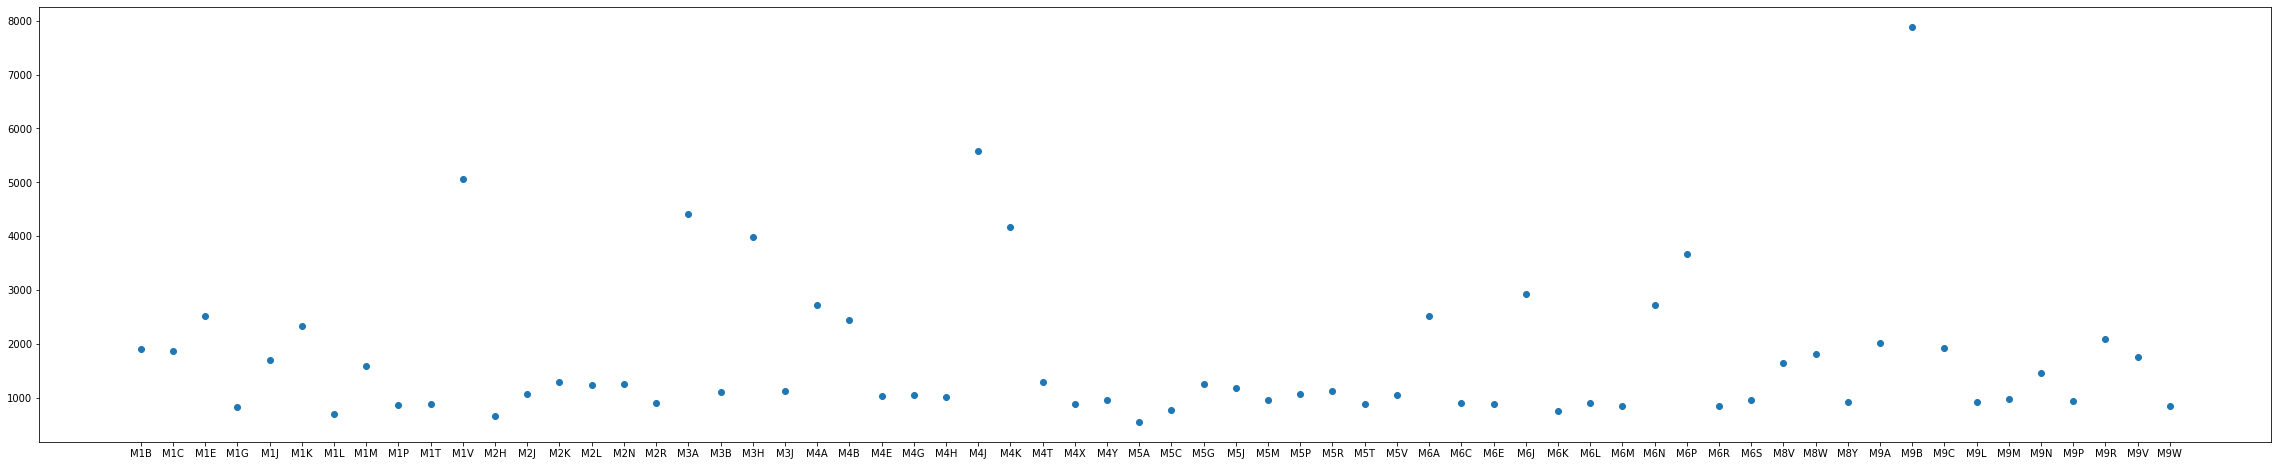

In [38]:
plt.figure(figsize=(40, 8))
plt.scatter(df_income_plot.index, df_income_plot['Tenant Average Rent'])
plt.show()

In [39]:
plt.figure(figsize=(40, 8))
plt.scatter(df_income_plot.index, df_income_plot['Average Family Income'])
plt.scatter(df_income_plot.index, df_income_plot['Tenant Average Rent'])
plt.show()

### Obserations:

#### 1. The Chinese dominate as a linguistic group in areas especially where average income is high but this does not seem very strongly supported by the correlation.
#### 2. Average rent eventually flattens out across the areas when compared to income. Oddly enough,
####    the area with the highest rent is not in the same area where the highest average income is.
#### 3. The area with the largest population also tended to have more representative ethno-linguistic groups.
#### 4. We will look further into areas (M1B, M1V, M2L)

In [40]:
#load neighbourhood data
neighbourhood_file='./data/neighborhoods/neighbourhood-profiles-2016-edit.csv'
df_neighbourhood = pd.read_csv(neighbourhood_file)
#clean out extra spaces in column names
df_neighbourhood.columns=df_neighbourhood.columns.str.strip()

In [41]:
df_neighbourhood.head()

_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
3    4                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   

                      Data Source               Characteristic  \
0                 City of Toronto         Neighbourhood Number   
1                 City of Toronto         TSNS2020 Designation   
2  Census Profile 98-316-X2016001             Population, 2016   
3  Census Profile 98-316-X2016001             Population, 2011   
4  Census Profile 98-316-X2016001  Population Change 2011-2016   

  City of Toronto Agincourt North Agincourt South-Malvern West  \
0             NaN             129                          128   
1             NaN  No Designation               No Designation   
2         2731571           29113                        23757   
3         2615060           30279                        21988   
4           4.50%          -3.90%                        8.00%   

        Alderwood           Annex Banbury-Don Mills  Bathurst Manor  \
0              20              95                42              34   
1  No Designation  No Designation    No Designation  No Designation   
2           12054           30526             27695           15873   
3           11904           29177             26918           15434   
4           1.30%           4.60%             2.90%           2.80%   

  Bay Street Corridor Bayview Village Bayview Woods-Steeles  \
0                  76              52                    49   
1      No Designation  No Designation        No Designation   
2               25797           21396                 13154   
3               19348           17671                 13530   
4              33.30%          21.10%                -2.80%   

  Bedford Park-Nortown Beechborough-Greenbrook         Bendale  \
0                   39                     112             127   
1       No Designation                     NIA  No Designation   
2                23236                    6577           29960   
3                23185                    6488           27876   
4                0.20%                   1.40%           7.50%   

  Birchcliffe-Cliffside Black Creek     Blake-Jones Briar Hill-Belgravia  \
0                   122          24              69                  108   
1        No Designation         NIA  No Designation       No Designation   
2                 22291       21737            7727                14257   
3                 21856       22057            7763                14302   
4                 2.00%      -1.50%          -0.50%               -0.30%   

  Bridle Path-Sunnybrook-York Mills Broadview North Brookhaven-Amesbury  \
0                                41              57                  30   
1                    No Designation  No Designation      No Designation   
2                              9266           11499               17757   
3                              8713           11563               17787   
4                             6.30%          -0.60%              -0.20%   

  Cabbagetown-South St. James Town Caledonia-Fairbank       Casa Loma  \
0                               71                109              96   
1                   No Designation     No Designation  No Designation   
2                            11669               9955           10968   
3                            12053               9851           10487   
4                           -3.20%              1.10%           4.60%   

  Centennial Scarborough Church-Yonge Corridor Clairlea-Birchmount  \
0                    133                    75                 120   
1         No Designation        No Designation      No Designation   
2                  13362                 31340               269

In [42]:
df_neighbourhood.drop(columns=['Category','Topic','Data Source','Unnamed: 146','Unnamed: 147','Unnamed: 148'], inplace=True)
df_neighbourhood.drop(df_neighbourhood.index[1],inplace=True)

In [43]:
#df_neighbourhood.set_index('_id',inplace=True)

In [44]:
df_checkincome=df_neighbourhood.loc[df_neighbourhood['_id'].isin(['361','1110','1111','1112','1113','1114'])]
df_checkincome

_id               Characteristic City of Toronto Agincourt North  \
230   361            Chinese languages          245285           14670   
710  1110         In the bottom decile          404560            4195   
711  1111         In the second decile          320165            5030   
712  1112          In the third decile          268500            3700   
713  1113         In the fourth decile          238680            2990   
714  1114          In the fifth decile          223410            2610   

    Agincourt South-Malvern West Alderwood Annex Banbury-Don Mills  \
230                         9935       190  1530              3430   
710                         3905       725  4810              2600   
711                         3565       815  2225              2195   
712                         2940      1005  1710              2050   
713                         2590      1060  1630              1875   
714                         2210      1140  1735              2045   

    Bathurst Manor Bay Street Corridor Bayview Village Bayview Woods-Steeles  \
230            415                6440            4895                  3690   
710           1825                8820            4005                  1760   
711           1865                2020            1995                  1315   
712           1595                1660            1585                  1085   
713           1455                1380            1550                  1025   
714           1410                1350            1620                   905   

    Bedford Park-Nortown Beechborough-Greenbrook Bendale  \
230                  620                      60    3970   
710                 1600                    1200    4795   
711                 1460                    1125    4065   
712                 1300                     870    3525   
713                 1225                     770    3245   
714                 1095                     590    2680   

    Birchcliffe-Cliffside Black Creek Blake-Jones Briar Hill-Belgravia  \
230                   710         620         685                  275   
710                  2405        4670        1365                 1785   
711                  1865        4695        1000                 1720   
712                  1855        3495         655                 1770   
713                  1685        2545         540                 1765   
714                  1800        1910         510                 1690   

    Bridle Path-Sunnybrook-York Mills Broadview North Brookhaven-Amesbury  \
230                               990             340                 445   
710                               695            1765                2930   
711                               285            1530                2925   
712                               300            1270                2680   
713                               270            1065                2130   
714                               250             925                1720   

    Cabbagetown-South St. James Town Caledonia-Fairbank Casa Loma  \
230                              515                125       290   
710                             1840               1035      1085   
711                             1130               1095       690   
712                              770               1140       545   
713                              755               1190       515   
714                              755               1200       560   

    Centennial Scarborough Church-Yonge Corridor Clairlea-Birchmount  \
230                    410                  3050                1765   
710                    605                  7050                3605   
711                    625                  2710                3275   
712                    715                  2090                2870   
713                    830                  2050                2615   
714                    985             

In [45]:
df_checkincome1=df_checkincome.drop(columns=['Characteristic','City of Toronto'])

In [46]:
df_checkincome1=df_checkincome1.infer_objects()
#df_neighbourhood_t.drop(df_neighbourhood_t.index[0],inplace=True)

In [47]:
df_checkincome1=df_checkincome1.T

In [48]:
df_checkincome1.astype('float').corr()

230       710       711       712       713       714
230  1.000000  0.535922  0.445532  0.400154  0.375390  0.377489
710  0.535922  1.000000  0.827265  0.758598  0.735213  0.717851
711  0.445532  0.827265  1.000000  0.968696  0.928169  0.872569
712  0.400154  0.758598  0.968696  1.000000  0.982634  0.944994
713  0.375390  0.735213  0.928169  0.982634  1.000000  0.981714
714  0.377489  0.717851  0.872569  0.944994  0.981714  1.000000

#### Seems like linguistic background has a weak correlation on income but notice the trend.

In [49]:
#load employment data
employment_file='./data/neighborhoods/Emp2019.xlsx'
df_employment = pd.read_excel(employment_file,
                     sheet_name='Table 5',header=2)
df_employment.columns=['Number','Secondary Plan Area','Manufacturing','Retail','Service','Office','Institutional','Community/Entertainment','Total']
df_employment=df_employment.dropna()

In [50]:
df_employment

Number              Secondary Plan Area  Manufacturing  Retail  Service  \
0       1                        Agincourt          730.0   710.0    650.0   
1      24                Central Don Mills           10.0   800.0   1190.0   
2      22                    Central Finch            0.0    30.0     60.0   
3      27                Davenport Village            0.0     0.0     10.0   
4       7                   Downsview Area         4100.0   900.0   1760.0   
5      26                    Emery Village           40.0   110.0    230.0   
6      12                 Etobicoke Centre           40.0   670.0   1270.0   
7      13          Fort York Neighbourhood           10.0    10.0     90.0   
8      14            Garrison Common North          610.0  1560.0   2700.0   
9       2                   Highland Creek            0.0    80.0    350.0   
10     15                  King-Parliament          240.0  1320.0   1990.0   
11     16                     King-Spadina          370.0  2010.0   8320.0   
12     32                   Lawrence-Allen           10.0  7160.0   2320.0   
13      3              Morningside Heights            0.0     0.0      0.0   
14     11                      Motel Strip           20.0    40.0    170.0   
15      8                North York Centre           50.0  1520.0   3530.0   
16      4     Port Union Village Community            0.0     0.0      0.0   
17     34                      Queen River           40.0   200.0     10.0   
18     18            Railway Lands Central            0.0    80.0   1740.0   
19     17               Railway Lands East          310.0   380.0   2510.0   
20     19               Railway Lands West            0.0   200.0    280.0   
21     28                      Regent Park           10.0   140.0    130.0   
22      5               Scarborough Centre          600.0  3410.0   1520.0   
23     29  Sheppard Avenue Commercial Area            0.0    30.0     50.0   
24      9    Sheppard East Subway Corridor           10.0  4090.0   1500.0   
25     23             Sheppard West/Dublin           20.0   370.0    420.0   
26     25                          Swansea          140.0   140.0     70.0   
27     20            University of Toronto           40.0   270.0    510.0   
28     30                     Warden Woods          320.0    20.0     50.0   
29     21                   Yonge Eglinton           80.0  2820.0   4140.0   
30      6                  Yonge St. Clair          130.0   800.0   1180.0   
31     10                  York University            0.0    60.0    650.0   

     Office  Institutional  Community/Entertainment    Total  
0    2370.0          210.0                     10.0   4680.0  
1    2010.0          930.0                    100.0   5040.0  
2     450.0           80.0                     10.0    630.0  
3      20.0            0.0                      0.0     20.0  
4    1000.0         1560.0                    230.0   9550.0  
5     280.0          260.0                     10.0    920.0  
6    7580.0         1040.0                    250.0  10850.0  
7      60.0          480.0                    260.0    920.0  
8   14530.0         2970.0                    370.0  22740.0  
9     410.0         4160.0                    440.0   5440.0  
10  10600.0         2340.0                    510.0  17000.0  
11  31300.0         1040.0                   2050.0  45080.0  
12   5220.0         2900.0                    250.0  17880.0  
13      0.0          190.0                     90.0    280.0  
14    170.0           90.0                      0.0    480.0  
15  28340.0         1920.0                    550.0  35920.0  
16      0.0            0.0                      0.0      0.0  
17     90.0          190.0                      0.0    520.0  
18   2610.0           20.0                   2190.0   6640.0  
19  15290.0           20.0                   4480.0  22990.0  
20    170.0           20.0                     10.0    680.0  
21    410.0          320.0                

In [51]:
df_employment['area']=df_employment['Secondary Plan Area'].apply(get_area)

Agincourt
Central Don Mills
Central Finch
Davenport Village
Downsview Area
Emery Village
Etobicoke Centre
Fort York Neighbourhood
Garrison Common North
Highland Creek
King-Parliament
King-Spadina
Lawrence-Allen
Morningside Heights
Motel Strip
North York Centre
Port Union Village Community
Queen River
Railway Lands Central
Railway Lands East
Railway Lands West
Regent Park
Scarborough Centre
Sheppard Avenue Commercial Area
Sheppard East Subway Corridor
Sheppard West/Dublin
Swansea
University of Toronto
Warden Woods
Yonge Eglinton
Yonge St. Clair
York University


In [52]:

df_employment.dropna().sort_values('area')


Number              Secondary Plan Area  Manufacturing  Retail  Service  \
9       2                   Highland Creek            0.0    80.0    350.0   
30      6                  Yonge St. Clair          130.0   800.0   1180.0   
0       1                        Agincourt          730.0   710.0    650.0   
1      24                Central Don Mills           10.0   800.0   1190.0   
4       7                   Downsview Area         4100.0   900.0   1760.0   
8      14            Garrison Common North          610.0  1560.0   2700.0   
7      13          Fort York Neighbourhood           10.0    10.0     90.0   
31     10                  York University            0.0    60.0    650.0   
5      26                    Emery Village           40.0   110.0    230.0   
3      27                Davenport Village            0.0     0.0     10.0   
16      4     Port Union Village Community            0.0     0.0      0.0   
24      9    Sheppard East Subway Corridor           10.0  4090.0   1500.0   
19     17               Railway Lands East          310.0   380.0   2510.0   
17     34                      Queen River           40.0   200.0     10.0   
21     28                      Regent Park           10.0   140.0    130.0   
18     18            Railway Lands Central            0.0    80.0   1740.0   
2      22                    Central Finch            0.0    30.0     60.0   
10     15                  King-Parliament          240.0  1320.0   1990.0   
6      12                 Etobicoke Centre           40.0   670.0   1270.0   
22      5               Scarborough Centre          600.0  3410.0   1520.0   
15      8                North York Centre           50.0  1520.0   3530.0   
27     20            University of Toronto           40.0   270.0    510.0   
11     16                     King-Spadina          370.0  2010.0   8320.0   
12     32                   Lawrence-Allen           10.0  7160.0   2320.0   
13      3              Morningside Heights            0.0     0.0      0.0   
26     25                          Swansea          140.0   140.0     70.0   
23     29  Sheppard Avenue Commercial Area            0.0    30.0     50.0   
20     19               Railway Lands West            0.0   200.0    280.0   

     Office  Institutional  Community/Entertainment    Total area  
9     410.0         4160.0                    440.0   5440.0  M1C  
30  10790.0         1050.0                    330.0  14260.0  M1L  
0    2370.0          210.0                     10.0   4680.0  M1S  
1    2010.0          930.0                    100.0   5040.0  M3B  
4    1000.0         1560.0                    230.0   9550.0  M3H  
8   14530.0         2970.0                    370.0  22740.0  M3H  
7      60.0          480.0                    260.0    920.0  M3J  
31    440.0        12910.0                     90.0  14150.0  M3J  
5     280.0          260.0                     10.0    920.0  M4A  
3      20.0            0.0                      0.0     20.0  M4A  
16      0.0            0.0                      0.0      0.0  M4A  
24   5440.0         4540.0                    310.0  15880.0  M4J  
19  15290.0           20.0                   4480.0  22990.0  M4J  
17     90.0          190.0                      0.0    520.0  M4K  
21    410.0          320.0                    160.0   1170.0  M5A  
18   2610.0           20.0                   2190.0   6640.0  M5G  
2     450.0           80.0                     10.0    630.0  M5G  
10  10600.0         2340.0                    510.0  17000.0  M5H  
6    7580.0         1040.0                    250.0  10850.0  M5K  
22  10390.0          570.0                    340.0  16830.0  M5K  
15  28340.0         1920.0                    550.0  35920.0  M5K  
27   1880.0        15710.0                    670.0  19080.0  M5S  
11  31300.0         1040.0                   2050.0  45080.0  M5V  
12   5220.0         2900.0                    250.0  17880.0  M6A  
13      0.0          190.0              

In [53]:
df_employment.loc[df_employment['Total'].idxmax()][['area','Secondary Plan Area','Manufacturing','Retail','Service','Office','Institutional','Community/Entertainment']]

area                                M5V
Secondary Plan Area        King-Spadina
Manufacturing                       370
Retail                             2010
Service                            8320
Office                            31300
Institutional                      1040
Community/Entertainment            2050
Name: 11, dtype: object

In [54]:
df_employment.loc[df_employment['Institutional'].idxmax()][['area','Secondary Plan Area','Manufacturing','Retail','Service','Office','Institutional','Community/Entertainment']]

area                                         M5S
Secondary Plan Area        University of Toronto
Manufacturing                                 40
Retail                                       270
Service                                      510
Office                                      1880
Institutional                              15710
Community/Entertainment                      670
Name: 27, dtype: object

In [55]:
df_employment.loc[df_employment['Office'].idxmax()][['area','Secondary Plan Area','Manufacturing','Retail','Service','Office','Institutional','Community/Entertainment']]

area                                M5V
Secondary Plan Area        King-Spadina
Manufacturing                       370
Retail                             2010
Service                            8320
Office                            31300
Institutional                      1040
Community/Entertainment            2050
Name: 11, dtype: object

In [56]:
df_employment.loc[df_employment['Manufacturing'].idxmax()][['area','Secondary Plan Area','Manufacturing','Retail','Service','Office','Institutional','Community/Entertainment']]

area                                  M3H
Secondary Plan Area        Downsview Area
Manufacturing                        4100
Retail                                900
Service                              1760
Office                               1000
Institutional                        1560
Community/Entertainment               230
Name: 4, dtype: object

In [57]:
df_employment.describe()

Manufacturing       Retail     Service        Office  Institutional  \
count      32.000000    32.000000    32.00000     32.000000      32.000000   
mean      247.812500   935.312500  1231.25000   5542.187500    1865.000000   
std       730.796006  1541.423691  1703.45143   8575.634176    3527.497514   
min         0.000000     0.000000     0.00000      0.000000       0.000000   
25%         0.000000    55.000000    85.00000    222.500000     172.500000   
50%        30.000000   235.000000   580.00000    940.000000     400.000000   
75%       165.000000  1005.000000  1745.00000   8282.500000    2025.000000   
max      4100.000000  7160.000000  8320.00000  31300.000000   15710.000000   

       Community/Entertainment        Total  
count                32.000000     32.00000  
mean                479.687500  10299.06250  
std                 914.466121  12040.29347  
min                   0.000000      0.00000  
25%                  10.000000    837.50000  
50%                 195.000000   5240.00000  
75%                 387.500000  16872.50000  
max                4480.000000  45080.00000

In [63]:
df_employment.corr()

Manufacturing    Retail   Service    Office  \
Manufacturing                 1.000000  0.045216  0.146448  0.005875   
Retail                        0.045216  1.000000  0.467448  0.399142   
Service                       0.146448  0.467448  1.000000  0.904150   
Office                        0.005875  0.399142  0.904150  1.000000   
Institutional                -0.046916  0.102422  0.042782  0.012724   
Community/Entertainment       0.005318  0.072432  0.554819  0.531598   
Total                         0.078069  0.516846  0.908797  0.935632   

                         Institutional  Community/Entertainment     Total  
Manufacturing                -0.046916                 0.005318  0.078069  
Retail                        0.102422                 0.072432  0.516846  
Service                       0.042782                 0.554819  0.908797  
Office                        0.012724                 0.531598  0.935632  
Institutional                 1.000000                -0.007540  0.317827  
Community/Entertainment      -0.007540                 1.000000  0.540419  
Total                         0.317827                 0.540419  1.000000

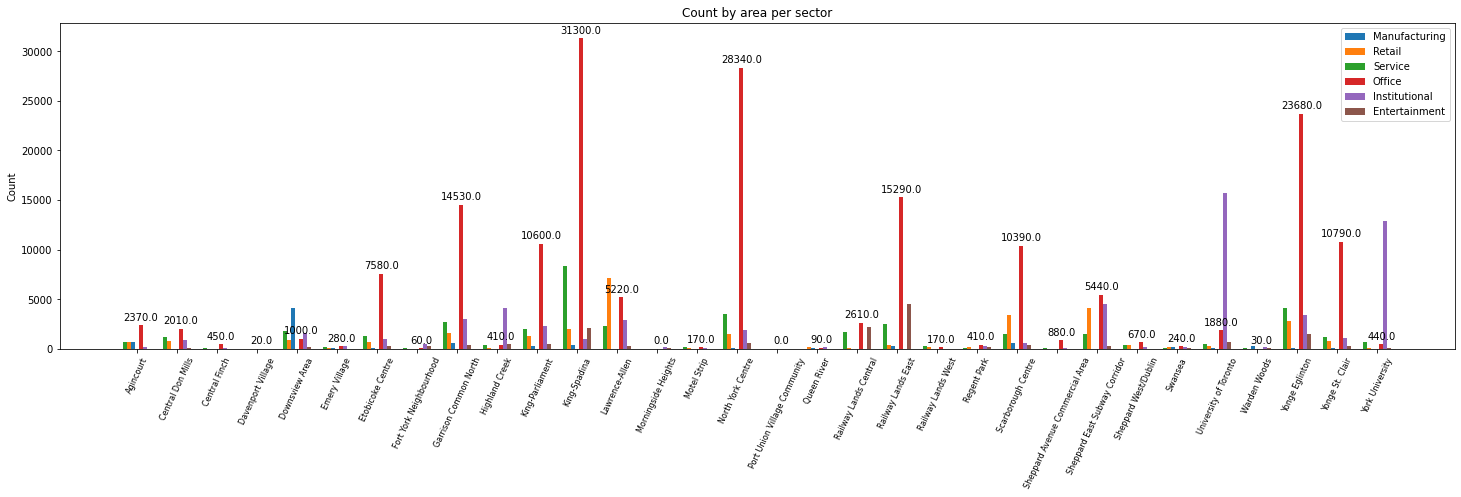

In [123]:
labels = df_employment['Secondary Plan Area']
manufacturing = df_employment['Manufacturing']
retail = df_employment['Retail']
service = df_employment['Service']
office = df_employment['Office']
institutional = df_employment['Institutional']
entertainment = df_employment['Community/Entertainment']

x = np.arange(len(labels))  # the label locations
width = 0.10  # the width of the bars

fig, ax = plt.subplots(figsize=(25,6))
rects1 = ax.bar(x - width, manufacturing, width, label='Manufacturing')
rects2 = ax.bar(x - width*2, retail, width, label='Retail')
rects3 = ax.bar(x - width*3, service, width, label='Service')
rects4 = ax.bar(x + width, office, width, label='Office')
rects5 = ax.bar(x + width*2, institutional, width, label='Institutional')
rects6 = ax.bar(x + width*3, entertainment, width, label='Entertainment')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Count by area per sector')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=8, rotation=65)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
autolabel(rects4)
#autolabel(rects5)
#autolabel(rects6)

plt.show()

### Obserations:

#### 1. Area M5V comes back as an area that has a large group of employees and large food business registrations.
#### 2. Oddly though, Institutional employment did not drive as mouch food business registrations.
#### 3. Office work is the largest source of employment followed by institutional employment. Manufacturing is a distant third.
#### 4. Among employment areas, (M3H, M5V, M5S) will be looked for further analysis.

In [64]:
focus_areas=['M3H', 'M5V', 'M5S', 'M1B', 'M1V', 'M2L', 'M9L', 'M5T', 'M9W', 'M3J',
             'M3B','M5J','M6A','M1T','M5R','M1G','M2N','M5G','M6K','M6R','M5R','M6J','M5T','M5A','M4Y','M5C']

#focus_areas=['M3H', 'M5V', 'M5S', 'M5T','M3J']
df_coordinates=df_coordinates[df_coordinates['area'].isin(focus_areas)]
df_coordinates

area   Latitude  Longitude
0    M1B  43.806686 -79.194353
3    M1G  43.770992 -79.216917
13   M1T  43.781638 -79.304302
14   M1V  43.815252 -79.284577
20   M2L  43.757490 -79.374714
22   M2N  43.770120 -79.408493
26   M3B  43.745906 -79.352188
28   M3H  43.754328 -79.442259
29   M3J  43.767980 -79.487262
52   M4Y  43.665860 -79.383160
53   M5A  43.654260 -79.360636
55   M5C  43.651494 -79.375418
57   M5G  43.657952 -79.387383
59   M5J  43.640816 -79.381752
65   M5R  43.672710 -79.405678
66   M5S  43.662696 -79.400049
67   M5T  43.653206 -79.400049
68   M5V  43.628947 -79.394420
71   M6A  43.718518 -79.464763
77   M6J  43.647927 -79.419750
78   M6K  43.636847 -79.428191
83   M6R  43.648960 -79.456325
96   M9L  43.756303 -79.565963
102  M9W  43.706748 -79.594054

In [65]:
venue_list=[]
for row in df_coordinates.itertuples(index=False):
    venue_list.extend(get_location(row))

df_venues = pd.DataFrame(venue_list)

M1B
M1G
M1T
M1V
M2L
M2N
M3B
M3H
M3J
M4Y
M5A
M5C
M5G
M5J
M5R
M5S
M5T
M5V
M6A
M6J
M6K
M6R
M9L
M9W


In [66]:
df_venues.columns=['area','latitude','longitude','name','lat','long','categories']

In [67]:
print('There are {} uniques categories.'.format(len(df_venues['categories'].unique())))
df_venues.shape

There are 196 uniques categories.


(710, 7)

In [68]:
df_venues.head(20)

area   latitude  longitude                                       name  \
0   M1B  43.806686 -79.194353                                    Wendy’s   
1   M1G  43.770992 -79.216917                                  Starbucks   
2   M1G  43.770992 -79.216917                                Tim Hortons   
3   M1G  43.770992 -79.216917                         Korean Grill House   
4   M1G  43.770992 -79.216917  El rey del cabrito, monterrey city mexico   
5   M1T  43.781638 -79.304302                     Remezzo Italian Bistro   
6   M1T  43.781638 -79.304302         The Royal Chinese Restaurant 避風塘小炒   
7   M1T  43.781638 -79.304302                              Eight Noodles   
8   M1T  43.781638 -79.304302                                   Kub Khao   
9   M1T  43.781638 -79.304302                            TD Canada Trust   
10  M1T  43.781638 -79.304302                               Petro-Canada   
11  M1T  43.781638 -79.304302                                        KFC   
12  M1T  43.781638 -79.304302                       Little Caesars Pizza   
13  M1T  43.781638 -79.304302                  Popeyes Louisiana Kitchen   
14  M1T  43.781638 -79.304302              Warden Ave. & Sheppard Ave. E   
15  M1T  43.781638 -79.304302                                     Rexall   
16  M1T  43.781638 -79.304302                                Gusto Pizza   
17  M1V  43.815252 -79.284577                          Queen Pastisserie   
18  M1V  43.815252 -79.284577                            Port Royal Park   
19  M1V  43.815252 -79.284577          Milliken Public School Playground   

          lat       long             categories  
0   43.807448 -79.199056   Fast Food Restaurant  
1   43.770037 -79.221156            Coffee Shop  
2   43.770827 -79.223078            Coffee Shop  
3   43.770812 -79.214502  Korean BBQ Restaurant  
4   43.768800 -79.219800     Mexican Restaurant  
5   43.778649 -79.308264     Italian Restaurant  
6   43.780505 -79.298844     Chinese Restaurant  
7   43.778234 -79.308299           Noodle House  
8   43.780438 -79.299837        Thai Restaurant  
9   43.779169 -79.303617                   Bank  
10  43.779337 -79.307682            Gas Station  
11  43.780400 -79.300700   Fast Food Restaurant  
12  43.780563 -79.298624            Pizza Place  
13  43.780476 -79.298460    Fried Chicken Joint  
14  43.778500 -79.307677           Intersection  
15  43.780900 -79.298764               Pharmacy  
16  43.783607 -79.298983            Pizza Place  
17  43.815492 -79.289715                 Bakery  
18  43.815477 -79.289773                   Park  
19  43.815383 -79.289867             Playground

In [69]:
# one hot encoding
df_foursq_onehotenc = pd.get_dummies(df_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_foursq_onehotenc['area'] = df_venues['area'] 

# move neighborhood column to the first column
fixed_columns = [df_foursq_onehotenc.columns[-1]] + list(df_foursq_onehotenc.columns[:-1])
df_foursq_onehotenc = df_foursq_onehotenc[fixed_columns]

df_foursq_onehotenc.head(20)

area  Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0   M1B                  0                  0        0                   0   
1   M1G                  0                  0        0                   0   
2   M1G                  0                  0        0                   0   
3   M1G                  0                  0        0                   0   
4   M1G                  0                  0        0                   0   
5   M1T                  0                  0        0                   0   
6   M1T                  0                  0        0                   0   
7   M1T                  0                  0        0                   0   
8   M1T                  0                  0        0                   0   
9   M1T                  0                  0        0                   0   
10  M1T                  0                  0        0                   0   
11  M1T                  0                  0        0                   0   
12  M1T                  0                  0        0                   0   
13  M1T                  0                  0        0                   0   
14  M1T                  0                  0        0                   0   
15  M1T                  0                  0        0                   0   
16  M1T                  0                  0        0                   0   
17  M1V                  0                  0        0                   0   
18  M1V                  0                  0        0                   0   
19  M1V                  0                  0        0                   0   

    Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0              0               0                0                 0   
1              0               0                0                 0   
2              0               0                0                 0   
3              0               0                0                 0   
4              0               0                0                 0   
5              0               0                0                 0   
6              0               0                0                 0   
7              0               0                0                 0   
8              0               0                0                 0   
9              0               0                0                 0   
10             0               0                0                 0   
11             0               0                0                 0   
12             0               0                0                 0   
13             0               0                0                 0   
14             0               0                0                 0   
15             0               0                0                 0   
16             0               0                0                 0   
17             0               0                0                 0   
18             0               0                0                 0   
19             0               0                0                 0   

    American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                     0             0         0            0           0   
1                     0             0         0            0           0   
2                     0             0         0            0           0   
3                     0             0         0            0           0   
4                     0             0         0            0           0   
5                     0             0         0            0           0   
6                     0             0         0            0           0   
7                     0             0         0            0           0   
8                     0             0         0            0           0   
9                     0             0         0            0           0   
10                    0             

In [70]:
df_grouped = df_foursq_onehotenc.groupby('area').mean().reset_index()
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['area'] = df_grouped['area']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

area 1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0  M1B  Fast Food Restaurant            Yoga Studio   Distribution Center   
1  M1G           Coffee Shop  Korean BBQ Restaurant    Mexican Restaurant   
2  M1T           Pizza Place           Intersection                  Bank   
3  M1V                  Park             Playground                Bakery   
4  M2L   Martial Arts School            Event Space  Ethiopian Restaurant   

  4th Most Common Venue 5th Most Common Venue        6th Most Common Venue  \
0  Ethiopian Restaurant           Escape Room            Electronics Store   
1           Yoga Studio   Distribution Center                  Escape Room   
2    Italian Restaurant    Chinese Restaurant          Fried Chicken Joint   
3        Discount Store           Escape Room            Electronics Store   
4           Escape Room     Electronics Store  Eastern European Restaurant   

         7th Most Common Venue        8th Most Common Venue  \
0  Eastern European Restaurant          Dumpling Restaurant   
1            Electronics Store  Eastern European Restaurant   
2         Fast Food Restaurant              Thai Restaurant   
3  Eastern European Restaurant          Dumpling Restaurant   
4          Dumpling Restaurant                    Drugstore   

  9th Most Common Venue 10th Most Common Venue  
0             Drugstore             Donut Shop  
1   Dumpling Restaurant              Drugstore  
2           Gas Station               Pharmacy  
3             Drugstore             Donut Shop  
4            Donut Shop       Doner Restaurant

In [71]:
df_grouped_clustering = df_grouped.drop('area', 1)
df_grouped_clustering

Accessories Store  Afghan Restaurant   Airport  Airport Food Court  \
0            0.000000           0.000000  0.000000            0.000000   
1            0.000000           0.000000  0.000000            0.000000   
2            0.000000           0.000000  0.000000            0.000000   
3            0.000000           0.000000  0.000000            0.000000   
4            0.000000           0.000000  0.000000            0.000000   
5            0.000000           0.000000  0.000000            0.000000   
6            0.000000           0.000000  0.000000            0.000000   
7            0.000000           0.000000  0.000000            0.000000   
8            0.000000           0.000000  0.000000            0.000000   
9            0.000000           0.013333  0.000000            0.000000   
10           0.000000           0.000000  0.000000            0.000000   
11           0.000000           0.000000  0.000000            0.000000   
12           0.000000           0.000000  0.000000            0.000000   
13           0.000000           0.000000  0.000000            0.000000   
14           0.000000           0.000000  0.000000            0.000000   
15           0.000000           0.000000  0.000000            0.000000   
16           0.000000           0.000000  0.000000            0.000000   
17           0.000000           0.000000  0.058824            0.058824   
18           0.076923           0.000000  0.000000            0.000000   
19           0.000000           0.000000  0.000000            0.000000   
20           0.000000           0.000000  0.000000            0.000000   
21           0.000000           0.000000  0.000000            0.000000   
22           0.000000           0.000000  0.000000            0.000000   
23           0.000000           0.000000  0.000000            0.000000   

    Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0       0.000000        0.000000         0.000000          0.000000   
1       0.000000        0.000000         0.000000          0.000000   
2       0.000000        0.000000         0.000000          0.000000   
3       0.000000        0.000000         0.000000          0.000000   
4       0.000000        0.000000         0.000000          0.000000   
5       0.000000        0.000000         0.000000          0.000000   
6       0.000000        0.000000         0.000000          0.000000   
7       0.000000        0.000000         0.000000          0.000000   
8       0.000000        0.000000         0.000000          0.000000   
9       0.000000        0.000000         0.000000          0.000000   
10      0.000000        0.000000         0.000000          0.000000   
11      0.000000        0.000000         0.000000          0.000000   
12      0.000000        0.000000         0.000000          0.000000   
13      0.000000        0.000000         0.000000          0.000000   
14      0.000000        0.000000         0.000000          0.000000   
15      0.000000        0.000000         0.000000          0.000000   
16      0.000000        0.000000         0.000000          0.000000   
17      0.058824        0.117647         0.117647          0.058824   
18      0.000000        0.000000         0.000000          0.000000   
19      0.000000        0.000000         0.000000          0.000000   
20      0.000000        0.000000         0.000000          0.000000   
21      0.000000        0.000000         0.000000          0.000000   
22      0.000000        0.000000         0.000000          0.000000   
23      0.000000        0.000000         0.000000          0.000000   

    American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0              0.000000      0.000000      0.00     0.000000    0.000000   
1              0.000000      0.000000      0.00     0.000000    0.000000   
2              0.000000      0.000000      0.00     0.000000    0.000000   
3              0.000000      0.000000      0.00     0.000000    0.000000 

In [72]:
# set number of clusters
kclusters = [2,3,4,5,6,7,8]
from sklearn.metrics import silhouette_samples, silhouette_score
df_grouped_clustering = df_grouped.drop('area', 1)

#iterate to find best K
for n_k in kclusters:
    # run k-means clustering
    kmeans = KMeans(n_clusters=n_k, random_state=10).fit(df_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    print(kmeans.labels_[0:10])
    silhouette_avg = silhouette_score(df_grouped_clustering, kmeans.labels_)
    print("For n_clusters =", n_k,
          "The average silhouette_score is :", silhouette_avg)


[0 0 0 0 1 0 0 0 0 0]
For n_clusters = 2 The average silhouette_score is : 0.5299334849479439
[2 0 0 0 1 0 0 0 0 0]
For n_clusters = 3 The average silhouette_score is : 0.5419331773812286
[2 0 0 0 1 0 0 0 0 0]
For n_clusters = 4 The average silhouette_score is : 0.4119717643879259
[4 1 1 3 2 1 1 1 1 1]
For n_clusters = 5 The average silhouette_score is : 0.34549969273926434
[4 5 1 3 2 1 1 1 1 1]
For n_clusters = 6 The average silhouette_score is : 0.33180961929889885
[1 6 0 4 2 0 0 0 0 0]
For n_clusters = 7 The average silhouette_score is : 0.30153418117615716
[1 6 0 3 2 0 0 0 0 0]
For n_clusters = 8 The average silhouette_score is : 0.26557830310098623


In [73]:
#from previous, set best K
k_best=3
# run k-means clustering using best K
kmeans = KMeans(n_clusters=k_best, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 2, 0, 0, 0, 0, 0], dtype=int32)

In [74]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [75]:
df_merged = df_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('area'), on='area')

df_merged.head(20) # check the last columns!

area   latitude  longitude                                       name  \
0   M1B  43.806686 -79.194353                                    Wendy’s   
1   M1G  43.770992 -79.216917                                  Starbucks   
2   M1G  43.770992 -79.216917                                Tim Hortons   
3   M1G  43.770992 -79.216917                         Korean Grill House   
4   M1G  43.770992 -79.216917  El rey del cabrito, monterrey city mexico   
5   M1T  43.781638 -79.304302                     Remezzo Italian Bistro   
6   M1T  43.781638 -79.304302         The Royal Chinese Restaurant 避風塘小炒   
7   M1T  43.781638 -79.304302                              Eight Noodles   
8   M1T  43.781638 -79.304302                                   Kub Khao   
9   M1T  43.781638 -79.304302                            TD Canada Trust   
10  M1T  43.781638 -79.304302                               Petro-Canada   
11  M1T  43.781638 -79.304302                                        KFC   
12  M1T  43.781638 -79.304302                       Little Caesars Pizza   
13  M1T  43.781638 -79.304302                  Popeyes Louisiana Kitchen   
14  M1T  43.781638 -79.304302              Warden Ave. & Sheppard Ave. E   
15  M1T  43.781638 -79.304302                                     Rexall   
16  M1T  43.781638 -79.304302                                Gusto Pizza   
17  M1V  43.815252 -79.284577                          Queen Pastisserie   
18  M1V  43.815252 -79.284577                            Port Royal Park   
19  M1V  43.815252 -79.284577          Milliken Public School Playground   

          lat       long             categories  Cluster Labels  \
0   43.807448 -79.199056   Fast Food Restaurant               1   
1   43.770037 -79.221156            Coffee Shop               0   
2   43.770827 -79.223078            Coffee Shop               0   
3   43.770812 -79.214502  Korean BBQ Restaurant               0   
4   43.768800 -79.219800     Mexican Restaurant               0   
5   43.778649 -79.308264     Italian Restaurant               0   
6   43.780505 -79.298844     Chinese Restaurant               0   
7   43.778234 -79.308299           Noodle House               0   
8   43.780438 -79.299837        Thai Restaurant               0   
9   43.779169 -79.303617                   Bank               0   
10  43.779337 -79.307682            Gas Station               0   
11  43.780400 -79.300700   Fast Food Restaurant               0   
12  43.780563 -79.298624            Pizza Place               0   
13  43.780476 -79.298460    Fried Chicken Joint               0   
14  43.778500 -79.307677           Intersection               0   
15  43.780900 -79.298764               Pharmacy               0   
16  43.783607 -79.298983            Pizza Place               0   
17  43.815492 -79.289715                 Bakery               0   
18  43.815477 -79.289773                   Park               0   
19  43.815383 -79.289867             Playground               0   

   1st Most Common Venue  2nd Most Common Venue 3rd Most Common Venue  \
0   Fast Food Restaurant            Yoga Studio   Distribution Center   
1            Coffee Shop  Korean BBQ Restaurant    Mexican Restaurant   
2            Coffee Shop  Korean BBQ Restaurant    Mexican Restaurant   
3            Coffee Shop  Korean BBQ Restaurant    Mexican Restaurant   
4            Coffee Shop  Korean BBQ Restaurant    Mexican Restaurant   
5            Pizza Place           Intersection                  Bank   
6            Pizza Place           Intersection                  Bank   
7            Pizza Place           Intersection                  Bank   
8            Pizza Place           Intersection                  Bank   
9            Pizza Place           Intersection                  Bank   
10           Pizza Place           Intersection                  Bank   
11           Pizza Place           Intersection                  Bank   
12           Pizza Place           Intersection  

In [76]:
df_merged.tail(150)

area   latitude  longitude  \
560  M5T  43.653206 -79.400049   
561  M5T  43.653206 -79.400049   
562  M5T  43.653206 -79.400049   
563  M5T  43.653206 -79.400049   
564  M5T  43.653206 -79.400049   
565  M5T  43.653206 -79.400049   
566  M5T  43.653206 -79.400049   
567  M5T  43.653206 -79.400049   
568  M5T  43.653206 -79.400049   
569  M5T  43.653206 -79.400049   
570  M5T  43.653206 -79.400049   
571  M5T  43.653206 -79.400049   
572  M5T  43.653206 -79.400049   
573  M5T  43.653206 -79.400049   
574  M5T  43.653206 -79.400049   
575  M5T  43.653206 -79.400049   
576  M5T  43.653206 -79.400049   
577  M5T  43.653206 -79.400049   
578  M5T  43.653206 -79.400049   
579  M5T  43.653206 -79.400049   
580  M5T  43.653206 -79.400049   
581  M5T  43.653206 -79.400049   
582  M5T  43.653206 -79.400049   
583  M5T  43.653206 -79.400049   
584  M5T  43.653206 -79.400049   
585  M5T  43.653206 -79.400049   
586  M5T  43.653206 -79.400049   
587  M5T  43.653206 -79.400049   
588  M5T  43.653206 -79.400049   
589  M5V  43.628947 -79.394420   
590  M5V  43.628947 -79.394420   
591  M5V  43.628947 -79.394420   
592  M5V  43.628947 -79.394420   
593  M5V  43.628947 -79.394420   
594  M5V  43.628947 -79.394420   
595  M5V  43.628947 -79.394420   
596  M5V  43.628947 -79.394420   
597  M5V  43.628947 -79.394420   
598  M5V  43.628947 -79.394420   
599  M5V  43.628947 -79.394420   
600  M5V  43.628947 -79.394420   
601  M5V  43.628947 -79.394420   
602  M5V  43.628947 -79.394420   
603  M5V  43.628947 -79.394420   
604  M5V  43.628947 -79.394420   
605  M5V  43.628947 -79.394420   
606  M6A  43.718518 -79.464763   
607  M6A  43.718518 -79.464763   
608  M6A  43.718518 -79.464763   
609  M6A  43.718518 -79.464763   
610  M6A  43.718518 -79.464763   
611  M6A  43.718518 -79.464763   
612  M6A  43.718518 -79.464763   
613  M6A  43.718518 -79.464763   
614  M6A  43.718518 -79.464763   
615  M6A  43.718518 -79.464763   
616  M6A  43.718518 -79.464763   
617  M6A  43.718518 -79.464763   
618  M6A  43.718518 -79.464763   
619  M6J  43.647927 -79.419750   
620  M6J  43.647927 -79.419750   
621  M6J  43.647927 -79.419750   
622  M6J  43.647927 -79.419750   
623  M6J  43.647927 -79.419750   
624  M6J  43.647927 -79.419750   
625  M6J  43.647927 -79.419750   
626  M6J  43.647927 -79.419750   
627  M6J  43.647927 -79.419750   
628  M6J  43.647927 -79.419750   
629  M6J  43.647927 -79.419750   
630  M6J  43.647927 -79.419750   
631  M6J  43.647927 -79.419750   
632  M6J  43.647927 -79.419750   
633  M6J  43.647927 -79.419750   
634  M6J  43.647927 -79.419750   
635  M6J  43.647927 -79.419750   
636  M6J  43.647927 -79.419750   
637  M6J  43.647927 -79.419750   
638  M6J  43.647927 -79.419750   
639  M6J  43.647927 -79.419750   
640  M6J  43.647927 -79.419750   
641  M6J  43.647927 -79.419750   
642  M6J  43.647927 -79.419750   
643  M6J  43.647927 -79.419750   
644  M6J  43.647927 -79.419750   
645  M6J  43.647927 -79.419750   
646  M6J  43.647927 -79.419750   
647  M6J  43.647927 -79.419750   
648  M6J  43.647927 -79.419750   
649  M6J  43.647927 -79.419750   
650  M6J  43.647927 -79.419750   
651  M6J  43.647927 -79.419750   
652  M6J  43.647927 -79.419750   
653  M6J  43.647927 -79.419750   
654  M6J  43.647927 -79.419750   
655  M6J  43.647927 -79.419750   
656  M6J  43.647927 -79.419750   
657  M6J  43.647927 -79.419750   
658  M6J  43.647927 -79.419750   
659  M6J  43.647927 -79.419750   
660  M6J  43.647927 -79.419750   
661  M6J  43.647927 -79.419750   
662  M6J  43.647927 -79.419750   
663  M6J  43.647927 -79.419750   
664  M6J  43.647927 -79.419750   
665  M6K  43.636847 -79.428191   
666  M6K  43.636847 -79.428191   
667  M6K  43.636847 -79.428191   
668  M6K  43.636847 -79.428191   
669  M6K  43.636847 -79.428191   
670  M6K  43.636847 -79.428191   
671  M6K  43.636847 -79.428191   
672  M6K  43.636847 -79.428191   
673  M6K  43.636847 -79.428191   
674  M6K  43.636847 -79.428191   
675  M6K  43.636847 -79.428191   
676  M6K  43.636847 -79.42

### Obserations:

#### 1. Area M5V which we saw earlier with the most employees working in offices also happens to 
#### be the transport hub for other forms of transport
#### 2. Area M5S which had the highest number of institutional employees, had a character close to
#### a university area which has coffee shops and bookstores. 
#### Interestingly, Area M3H which had the most manufacturing employees had the most number of banks.
#### Other areas with high number of population had a suburban character with parks, restaurants and playgrounds.

In [77]:
df_demographics.dtypes

area                                 object
Neighbourhood                        object
Neighbourhood Id                      int64
Total Area                          float64
Total Population                      int64
Pop - Males                           int64
Pop - Females                         int64
Pop 0 - 4 years                       int64
Pop 5 - 9 years                       int64
Pop 10 - 14 years                     int64
Pop 15 -19 years                      int64
Pop 20 - 24 years                     int64
Pop  25 - 29 years                    int64
Pop 30 - 34 years                     int64
Pop 35 - 39 years                     int64
Pop 40 - 44 years                     int64
Pop 45 - 49 years                     int64
Pop 50 - 54 years                     int64
Pop 55 - 59 years                     int64
Pop 60 - 64 years                     int64
Pop 65 - 69 years                     int64
Pop 70 - 74 years                     int64
Pop 75 - 79 years               

In [78]:
df_demographics['area_cd']=df_demographics['Neighbourhood Id'].apply(str)
df_demographics['area_cd']=df_demographics['area_cd'].apply(lambda x: x.zfill(3))

In [79]:
#Create chloropleth map
geojson_file='./data/neighborhoods/toronto_crs84.geojson'
geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode("Toronto, Canada")
center_latitude = location.latitude
center_longitude = location.longitude
# create a plain toronto map
toronto_map = folium.Map(location=[center_latitude, center_longitude], zoom_start=11)
# generate choropleth map using 
toronto_map.choropleth(
    geo_data=geojson_file,
    data=df_demographics,
    columns=['area_cd','Total Population'],
    key_on='feature.properties.AREA_S_CD',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Density'
)

area_colors={'M3H':'#a6cee3','M5V':'#1f78b4','M5S':'#b2df8a','M1B':'#33a02c',
                'M1V':'#fb9a99','M2L':'#e31a1c','M9L':'#fdbf6f','M5T':'#ff7f00','M9W':'#cab2d6','M3J':'#e5c494'}

cluster_colors={0:'#fbb4ae',1:'#b3cde3',2:'#ccebc5',3:'orange',4:'#decbe4',5:'#fed9a6',6:'#ffffcc',7:'#e5d8bd',
               8:'red',9:'#fddaec',10:'#f2f2f2'}
for area, lat, lng, categories, name, cluster in zip(df_merged['area'], df_merged['lat'], df_merged['long'],
                                                         df_merged['categories'], df_merged['name'], df_merged['Cluster Labels']):
    label = '{}, {}, {}'.format(cluster, name, area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [lat, lng],
            radius=7,
            popup=label,
            color=cluster_colors[cluster],
            fill=True,
            #fill_color=gray,
            fill_opacity=0.9,
            parse_html=False).add_to(toronto_map)

# display map
toronto_map

/Users/gquisumbing/.pyenv/versions/3.7.3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
